In [2]:
import numpy as np
import nltk
import os
import string 
import pickle
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from num2words import num2words
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
import math
import heapq
import re
import copy
import random
import pandas as pd
from unidecode import unidecode
from sklearn.manifold import TSNE

In [2]:
ps = PorterStemmer()

### Loading Data

In [3]:
path = 'C:\\Users\\shekh\\Desktop\\Shekhar\\IR\\Assignment 1\\20_newsgroups'
folders = []
files = []
docs = []
names = []

#loading folders
for folder in os.listdir(path):
    folders.append(folder)
    
#print(folders)

subset = ['comp.graphics', 'sci.med','talk.politics.misc', 'rec.sport.hockey', 'sci.space']

docsdic = {}

#loading files from each folder 
for folder in folders:
    if folder in subset:
        newpath = path +'\\'+folder
        for file in tqdm(os.listdir(newpath)):
            try:
                f = open(newpath+'\\'+file,"r")
                #print(doc)
                doc = f.read()
                #adding files to list
                docs.append(doc)
                if folder in docsdic:
                    docsdic[folder].append(doc)
                else:
                    docsdic[folder] = [doc]
                names.append((file,folder))
                f.close()
            except:
                pass
            
      

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 179.87it/s]


In [4]:
print(docsdic.keys())

dict_keys(['comp.graphics', 'rec.sport.hockey', 'sci.med', 'sci.space', 'talk.politics.misc'])


In [5]:
listofkeys = list(docsdic.keys())
# print(listofkeys)
classmapidtoname = {}
classmapnametoid = {}
for i in range(len(listofkeys)):
    classmapidtoname[i] = listofkeys[i]
    classmapnametoid[listofkeys[i]] = i

# print(classmapidtoname)
# print(classmapnametoid)
    
# print(classmapidtoname.get(1))

In [6]:
def listtodict(keys, values):
    keys = keys.copy()
    values = values.copy()
    dic = {}
    for key in range(len(keys)): 
        for value in values: 
            dic[key] = value
            values.remove(value)
            break  
    return dic

In [7]:
def remove_metadata(documents):
    pos = documents.index('\n\n')
    fixed_docs = documents[pos:]
    return fixed_docs

In [8]:
def apply_proter_stemmer(string):
    for i in range(len(string)):
        string[i] = ps.stem(string[i])
    return string
        

In [9]:
def remove_stopword(string):
    stop_words = set(stopwords.words('english'))
    data = [w for w in string if not w in stop_words]
    return data

In [10]:
def convert_num(string):
    for i in range(len(string)):
        try:
            if(string[i].isnumeric()):
                string[i] = num2words(string[i])
        except:
            continue
    return string

In [11]:
def remove_nonascii(string):
    stripped = (c for c in string if 0 < ord(c) < 127)
    return ''.join(stripped)

In [12]:
def preprocessing(newdataset):
    dataset = newdataset.copy()
    for i in tqdm(range(len(dataset))):
        dataset[i] = dataset[i].lower()
        dataset[i] = remove_nonascii(dataset[i])
        dataset[i] = dataset[i].translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
        dataset[i] = dataset[i].split()
        dataset[i] = remove_stopword(dataset[i])
        dataset[i] = convert_num(dataset[i])
        dataset[i] = apply_proter_stemmer(dataset[i])
    return dataset

In [13]:
def querypreprocessing(stringdata):
    lower = stringdata.lower()
    punc = lower.translate(str.maketrans('','',string.punctuation))
    spl = punc.split()
    removestop = remove_stopword(spl)
    removenum = convert_num(removestop)
    stemmedquery = apply_proter_stemmer(removenum)
    
    for word in stemmedquery:
        if word not in vocab:
            stemmedquery.remove(word)
    
    return stemmedquery

In [14]:
def create_vocabulary(data):
    vocab = set()
    for doc in data:
        for word in doc:
            #print(word)
            vocab.add(word)
    return list(vocab)

In [15]:
def traintest_split(Dic, ratio):
    D = copy.deepcopy(Dic)
    train = {}
    test = []
    for key in tqdm(D.keys()):
        train[key] = random.sample(D[key],int(len(D[key])*(ratio/100)))
        for data in D[key]:
            if data not in train[key]:
                test.append(data)
    return train, test

### Performing text preprocessing steps in all docs in all classes
docs are stored in a dictionary where each ket represents a class, and docs are stored in list of lists

In [18]:
for key in docsdic.keys():
    docsdic[key] = preprocessing(docsdic[key])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.29it/s]


In [19]:
idtoname = listtodict(docs, names)

In [20]:
nametoid = {}
for i in range(len(names)):
    nametoid[names[i][1]] = i

In [24]:
vocab = []
s = set()
vm = []
for key in docsdic.keys():
    
    vm.extend(create_vocabulary(docsdic[key]))
a = set(vm)
v = list(s)
print(type(a))

<class 'set'>


In [25]:
def create_dataframe(vocab, data):
    df = pd.DataFrame()
    df['vocab'] = vocab
    
    
    tfall = []
    
    for i in tqdm(range(len(data))):
        tf1 = []
        for word in vocab:
            tf1.append(termfreq(data[i],word))
        #print(len(tf1))
        tfall.append(tf1)
    #print(tfall)
    
    for i in tqdm(range(len(tfall))):
        df.insert(i+1, i, tfall[i],allow_duplicates = False)
    
    df.set_index('vocab', inplace = True)
    
    return df

In [26]:
def get_mutual_information(class_tf_idf_series, class_tf_df_list):
    words = class_tf_idf_series.index
    Mutual_Information = {}
    Mutual_Information_each_class = pd.DataFrame()
    
    class_tf = pd.concat(class_tf_df_list, axis=1)
    class_tf.replace(np.nan, 0, inplace=True)
#     display(class_tf[class_tf>0])
    
    for i, class_tf_1 in tqdm(enumerate(class_tf_df_list)):
        in_class_df = class_tf.iloc[:, i*len(class_tf_1.columns):(i+1)*len(class_tf_1.columns)]
        not_in_class_df = class_tf.drop(in_class_df.columns, axis=1)
        
        # number of docs containing term and present in the class
        n11 = in_class_df[in_class_df>0].count(axis=1)

        # number of docs present in the class which doesn't have the term
        n01 = in_class_df[in_class_df == 0].count(axis=1)

        # number of docs containing term but does not present in the class
        n10 = not_in_class_df[not_in_class_df>0].count(axis=1)

        # number of docs doesn't have the term and not present in class
        n00 = not_in_class_df[not_in_class_df == 0].count(axis=1)
        
        n = n11+n01+n10+n00
        a = (n11/n)*np.log2((n*n11)/((n10+n11)*(n01+n11)))
        b = (n01/n)*np.log2((n*n01)/((n00+n01)*(n01+n11)))
        c = (n10/n)*np.log2((n*n10)/((n10+n11)*(n10+n00)))
        d = (n00/n)*np.log2((n*n00)/((n01+n00)*(n00+n10)))
            
        a.replace(np.nan, 0, inplace=True)
        b.replace(np.nan, 0, inplace=True)
        c.replace(np.nan, 0, inplace=True)
        d.replace(np.nan, 0, inplace=True)
    
        MI = a+b+c+d
        Mutual_Information_each_class = pd.concat([Mutual_Information_each_class, MI], axis=1)

    Mutual_Information_each_class.columns = class_tf_idf_series.columns
        
    return Mutual_Information_each_class

### Function to Train naive bayes

In [27]:
def trainaiveBayes(C):
    prior = []
    condprob = []
    
    vocab = []
    #create vocabulary
    for key in tqdm(C.keys()):
        vocab.extend(create_vocabulary(C[key]))
    
    vocab = list(set(vocab))

    N = 0
    for c in C.keys():
        N += len(C[c])
    #print(N)
    for c in C.keys():
        #print(c)
        Nc = len(C[c])
        #calculate prior probablitiy of each class
        prior.append(Nc/N)
        textc = []
        for doc in tqdm(C[c]):
            #get all the text in class
            textc.extend(doc)
        Tct = []
        for term in tqdm(vocab):
            #calculate Tct of each term in the vocab
            Tct.append((term,textc.count(term)))
        #print(Tct)
        prob = []
        
        for i in tqdm(range(len(vocab))):
            #calculate the conditional probability of each term
            prob.append((Tct[i][1]+1)/(len(textc)+len(vocab)))
        condprob.append(prob)
        #return vocabulary of the entire dataset, priop probability of each class and 2D array of conditional probability
    return vocab, prior, np.asarray(condprob)

### Function to test Naive Bayes

In [28]:
def testnaiveBayes(C, nbvocab, priornb, condprobnb, docs):
    #revieve the data returned from train naive bayes
    vocab = copy.deepcopy(nbvocab)
    prior = copy.deepcopy(priornb)
    condprob = copy.deepcopy(condprobnb)
    
    condprob.shape
    
    classify = []    
        
    # for each doc in test set calculate the score
    for doc in tqdm(docs):
        score_list = []
        for i in range(len(C)):
            #log of prior for class
            score = math.log10(prior[i])
            for term in doc:
                if term in vocab:
                    #log of cond probability
                    score += math.log10(condprob[i][vocab.index(term)])
                else:
                    score += 0
            score_list.append(score)
            score = math.log10(prior[i])
        classify.append(score_list.index(max(score_list)))
    #assign doc to class which go the maxmium score
    result = []
    for cls in classify:
        result.append(C[cls])
    
    return result

In [29]:
def termdocindex(vocab, docs):
    termdoc ={}
    for term in tqdm(vocab):
        for doc in docs:
            if term in doc:
                if term in termdoc:
                    termdoc[term].add(docs.index(doc))
                else:
                    termdoc[term] = {docs.index(doc)}
    return termdoc

In [30]:
def termfreq(data, word):
    if data.count(word) == 0:
        return 0.0
    else:
        return 1+(math.log10(data.count(word)))
        #return(data.count(word)/len(data))

In [31]:
def accuracy(docs, result, data):
    correct = 0
    
    for i,j in zip(docs,result):
        m = []
        if i in data[j]:
            correct += 1
            m.append(1)
        else:
            m.append(0)
        
    return(correct/len(result))

In [32]:
def tfidf_feature_selection(data):
    termsinclass = []
    wholedic = {}
    for key in data.keys():
        terms = []
        for docs in data[key]:
            terms.extend(docs)
            wholedic[key] = terms
        termsinclass.append(terms)
   # print(len(termsinclass))
    
    vocab = create_vocabulary(termsinclass)
    
    df = pd.DataFrame(columns = list(data.keys()))
    
    df['vocab'] = vocab
    df.set_index('vocab', inplace = True)
    #print(vocab == df.index.values)
    #termfreq(wholedic, "")
    keys = list(wholedic.keys())
    #print(keys)
    for key in keys:
        series = []
        for term in tqdm(df.index.values):
            series.append(termfreq(wholedic.get(key), term))
        df.loc[:,key] = series
    
    nonzero = np.count_nonzero(df,axis = 1) 
    #print(nonzero[3])
    idf = []
    for i in tqdm(range(len(nonzero))):
        #print(nonzero[i])
        idf.append(1/(1+(math.log10(df.shape[1]/nonzero[i]))))
    
    df['idf'] = idf
    
    return df

In [33]:
def create_tfidf(df1):
    df = df1.copy()
    df.iloc[:, 0:-1] = df.iloc[:, 0:-1].mul(df.iloc[:, -1], axis=0)
    #print(df)
    return df

In [34]:
def select_top(dataframe, percent):
    featuresdataframe = dataframe.copy()
    if 'idf' in featuresdataframe.columns:
        featuresdataframe = featuresdataframe.drop(labels = 'idf', axis = 1)
    feat = []
    for column in featuresdataframe.columns:
        feat.append(featuresdataframe[column].sort_values(ascending = False, axis=0).index.tolist())
        #print(featuresdataframe[column].sort_values(ascending = False, axis=0).index)
    for i in range(len(feat)):
        feat[i] = feat[i][:int(len(feat[i])*(percent/100))]
    
    return feat

In [35]:
def reduce_docs(features, dic):
    data = copy.deepcopy(dic)
#     for key in data.keys():
#         print(len(data[key][1]))
    
    for (i,key) in zip(features, data.keys()):
        newlist = []
        for j in data[key]:
            newlist.append(list(set(j).intersection(set(i))))
       # print(len(newlist))
        data[key] = newlist
                
    return data

In [36]:
def confusion_matrix(D, result, testdata):
    compgraphic = []
    hockey = []
    scimed = []
    space = []
    politics = []
    
    keys = list(D.keys())
    #print(keys)
    
    for i in range(len(result)):
        if result[i] =='comp.graphics':
            compgraphic.append(i)
        elif result[i] == 'sci.med':
            scimed.append(i)
        elif result[i] == 'talk.politics.misc':
            politics.append(i)
        elif result[i] == 'sci.space':
            space.append(i)
        else:
            hockey.append(i)
    comp = np.zeros(5)
    hock = np.zeros(5)
    sci = np.zeros(5)
    spa = np.zeros(5)
    pol = np.zeros(5)
    for i in compgraphic:
        for j in range(len(keys)):
            if testdata[i] in D[keys[j]]:
                #print(keys[j])
                comp[j] += 1
    
    for i in hockey:
        for j in range(len(keys)):
            if testdata[i] in D[keys[j]]:
                #print(keys[j])
                hock[j] += 1

    for i in scimed:
        for j in range(len(keys)):
            if testdata[i] in D[keys[j]]:
                #print(keys[j])
                sci[j] += 1
                
    for i in space:
        for j in range(len(keys)):
            if testdata[i] in D[keys[j]]:
                #print(keys[j])
                spa[j] += 1
                
    for i in politics:
        for j in range(len(keys)):
            if testdata[i] in D[keys[j]]:
                #print(keys[j])
                pol[j] += 1

    confusion = np.array([comp, hock,sci,spa,pol], np.int32)
    
    confusiondf = pd.DataFrame(data = confusion, index = keys, columns = ['comp.graphics-pred', 'rec.sport.hockey-pred', 'sci.med-pred', 'sci.space-pred', 'talk.politics.misc-pred'])
    
    return confusiondf

In [37]:
processedocs = preprocessing(docs)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:57<00:00, 42.59it/s]


In [38]:
vocabulary = create_vocabulary(processedocs)

In [42]:
vocabcomp = create_vocabulary(docsdic['comp.graphics'])
vocabhockey = create_vocabulary(docsdic['rec.sport.hockey'])
vocabscimed = create_vocabulary(docsdic['sci.med'])
vocabscispace = create_vocabulary(docsdic['sci.space'])
vocabpolitics = create_vocabulary(docsdic['talk.politics.misc'])

In [43]:
dfclasscomp = create_dataframe(vocabcomp,docsdic['comp.graphics'])
dfclasshock = create_dataframe(vocabhockey,docsdic['rec.sport.hockey'])
dfclassmed = create_dataframe(vocabscimed,docsdic['sci.med'])
dfclassspace = create_dataframe(vocabscispace,docsdic['sci.space'])
dfclasspol = create_dataframe(vocabpolitics,docsdic['talk.politics.misc'])

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


In [44]:
dflist = []
dflist.append(dfclasscomp)
dflist.append(dfclasshock)
dflist.append(dfclassmed)
dflist.append(dfclassspace)
dflist.append(dfclasspol)

### Spliting data into test and train sets with specified splits

In [45]:
train_data80, test_data20 = traintest_split(docsdic,80 )
train_data70, test_data30 = traintest_split(docsdic,70 )
train_data50, test_data50 = traintest_split(docsdic,50 )

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 208.34it/s]


### Create tfidf for each class to calculate tfidf features
Please be patient this will take sometime

In [46]:
tffeaturesdf80 = tfidf_feature_selection(train_data80)

100%|████████████████████████████████████████████████████████████████████████| 50149/50149 [00:00<00:00, 464362.92it/s]


In [47]:
tffeaturesdf70 = tfidf_feature_selection(train_data70)

100%|████████████████████████████████████████████████████████████████████████| 46710/46710 [00:00<00:00, 467926.01it/s]


In [48]:
tffeaturesdf50 = tfidf_feature_selection(train_data50)

100%|████████████████████████████████████████████████████████████████████████| 38143/38143 [00:00<00:00, 490099.98it/s]


In [49]:
tfidfdataframefeat80 = create_tfidf(tffeaturesdf80)

In [50]:
tfidfdataframefeat70 = create_tfidf(tffeaturesdf70)

In [51]:
tfidfdataframefeat50 = create_tfidf(tffeaturesdf50)

### Selecting top 40% features for each split

In [52]:
selected_features80 = select_top(tfidfdataframefeat80, 40)

In [53]:
selected_features70 = select_top(tfidfdataframefeat70,40)

In [54]:
selected_features50 = select_top(tfidfdataframefeat50, 40)

#### remove the terms from the docs that were not selected in feature selection

In [55]:
reduced_traindata80 = reduce_docs(selected_features80, train_data80)

In [56]:
reduced_traindata70 = reduce_docs(selected_features70, train_data70)

In [57]:
reduced_traindata50 = reduce_docs(selected_features50, train_data50)

### Train Naive Bayes for each spplit of data
Please be patient this will take some time

In [58]:
nbvocab80, priornb80, condprobnb80 = trainaiveBayes(reduced_traindata80) 

100%|███████████████████████████████████████████████████████████████████████| 50149/50149 [00:00<00:00, 1536282.74it/s]


In [59]:
nbvocab70, priornb70, condprobnb70 = trainaiveBayes(reduced_traindata70) 

100%|███████████████████████████████████████████████████████████████████████| 46710/46710 [00:00<00:00, 1723944.42it/s]


In [60]:
nbvocab50, priornb50, condprobnb50 = trainaiveBayes(reduced_traindata50) 

100%|███████████████████████████████████████████████████████████████████████| 38143/38143 [00:00<00:00, 1630220.69it/s]


### Test Naive Bayes with with each split of data

In [62]:
resultnb80 = testnaiveBayes(list(reduced_traindata80.keys()), nbvocab80, priornb80,condprobnb80, test_data20)

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [38:25<00:00,  2.31s/it]


In [63]:
resultnb70 = testnaiveBayes(list(reduced_traindata70.keys()), nbvocab70, priornb70,condprobnb70, test_data30)

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [54:45<00:00,  2.19s/it]


In [64]:
resultnb50 = testnaiveBayes(list(reduced_traindata50.keys()), nbvocab50, priornb50,condprobnb50, test_data50)

100%|████████████████████████████████████████████████████████████████████████████| 2498/2498 [1:10:42<00:00,  1.70s/it]


In [65]:
accu_list = []

### Calculate Accuracy for each split of Data with TF-IDF feature selection

In [67]:
accu_list.append(accuracy(test_data20,resultnb80,docsdic))

In [68]:
accu_list.append(accuracy(test_data30,resultnb70,docsdic))

In [69]:
accu_list.append(accuracy(test_data50,resultnb50,docsdic))

In [70]:
print("Accuracy 80-20: ",accu_list[0])
confusionmat80 = confusion_matrix(docsdic, resultnb80, test_data20)
confusionmat80

Accuracy 80-20:  0.978978978978979


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,200,1,4,8,1
rec.sport.hockey,0,199,2,0,0
sci.med,0,0,192,0,0
sci.space,1,0,1,191,3
talk.politics.misc,0,0,1,2,196


In [71]:
print("Accuracy 70-30: ",accu_list[1])
confusionmat70 = confusion_matrix(docsdic, resultnb70, test_data30)
confusionmat70

Accuracy 70-30:  0.9786666666666667


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,299,3,7,7,1
rec.sport.hockey,1,297,0,1,1
sci.med,0,0,287,1,1
sci.space,3,0,5,289,2
talk.politics.misc,0,0,2,2,296


In [72]:
print("Accuracy 50-50: ",accu_list[2])
confusionmat50 = confusion_matrix(docsdic, resultnb50, test_data50)
confusionmat50

Accuracy 50-50:  0.9791833466773419


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,499,2,16,7,1
rec.sport.hockey,1,496,2,0,0
sci.med,0,0,467,2,0
sci.space,1,0,15,490,5
talk.politics.misc,2,2,3,1,494


### Split vs Accuracy TF-IDF

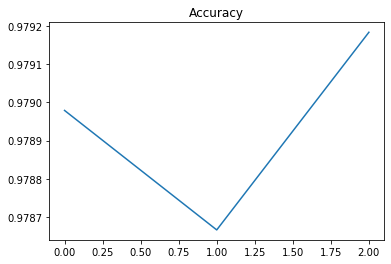

In [73]:
plt.plot(accu_list)
plt.title("Accuracy")
plt.show()

In [76]:
mitffeatures80 = copy.deepcopy(tffeaturesdf80)
mitffeatures80 = mitffeatures80.drop(labels = 'idf', axis = 1)
mitffeatures70 = copy.deepcopy(tffeaturesdf70)
mitffeatures70 = mitffeatures70.drop(labels = 'idf', axis = 1)
mitffeatures50 = copy.deepcopy(tffeaturesdf50)
mitffeatures50 = mitffeatures50.drop(labels = 'idf', axis = 1)

In [84]:
import warnings
warnings.filterwarnings("ignore")

### Calculate Mututal Information for each split of data
thankfully this only takes a few minutes

In [85]:
midf80 = get_mutual_information(mitffeatures80,dflist)

5it [00:19,  3.97s/it]


In [86]:
midf70 = get_mutual_information(mitffeatures70, dflist)

5it [00:15,  3.09s/it]


In [87]:
midf50 = get_mutual_information(mitffeatures50, dflist)

5it [00:22,  4.51s/it]


In [88]:
midf80selected = select_top(midf80, 40)

In [89]:
midf70selected = select_top(midf70, 40)

In [90]:
midf50selected = select_top(midf50, 40)

### Remove the words from the data that were not selected in the MI feature selection

In [91]:
midf80reduced_traindata = reduce_docs(midf80selected, train_data80)

In [92]:
midf70reduced_traindata = reduce_docs(midf70selected, train_data70)

In [93]:
midf50reduced_traindata = reduce_docs(midf50selected, train_data50)

### Train Naive Bayes for all Splits

In [94]:
mivocab80, priormi80, condprobmi80 = trainaiveBayes(midf80reduced_traindata) 

100%|███████████████████████████████████████████████████████████████████████| 20128/20128 [00:00<00:00, 1441599.52it/s]


In [95]:
mivocab70, priormi70, condprobmi70 = trainaiveBayes(midf70reduced_traindata) 

100%|███████████████████████████████████████████████████████████████████████| 18755/18755 [00:00<00:00, 1204086.44it/s]


In [96]:
mivocab50, priormi50, condprobmi50 = trainaiveBayes(midf50reduced_traindata) 

100%|████████████████████████████████████████████████████████████████████████| 15338/15338 [00:00<00:00, 984667.01it/s]


### Test Naive Bayes for all splits

In [97]:
resultmi80 = testnaiveBayes(list(midf80reduced_traindata.keys()), mivocab80, priormi80,condprobmi80, test_data20)

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [11:07<00:00,  1.50it/s]


In [98]:
resultmi70 = testnaiveBayes(list(midf70reduced_traindata.keys()), mivocab70, priormi70,condprobmi70, test_data30)

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [15:41<00:00,  1.59it/s]


In [99]:
resultmi50 = testnaiveBayes(list(midf50reduced_traindata.keys()), mivocab50, priormi50,condprobmi50, test_data50)

100%|██████████████████████████████████████████████████████████████████████████████| 2498/2498 [18:53<00:00,  2.20it/s]


In [100]:
accu_listmi = []

### Calculate Accuracy for all splits

In [101]:
accu_listmi.append(accuracy(test_data20,resultmi80,docsdic))

In [102]:
accu_listmi.append(accuracy(test_data30,resultmi70,docsdic))

In [103]:
accu_listmi.append(accuracy(test_data50,resultmi50,docsdic))

In [104]:
print("Accuracy 80-20: ",accu_listmi[0])
confusion_matrix(docsdic,resultmi80,test_data20)

Accuracy 80-20:  0.9579579579579579


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,199,1,6,14,3
rec.sport.hockey,0,199,3,1,1
sci.med,1,0,187,1,1
sci.space,1,0,2,182,5
talk.politics.misc,0,0,2,3,190


In [105]:
print("Accuracy 70-30: ",accu_listmi[1])
confusion_matrix(docsdic,resultmi70,test_data30)

Accuracy 70-30:  0.9733333333333334


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,301,1,4,14,1
rec.sport.hockey,0,298,4,1,3
sci.med,1,0,288,1,1
sci.space,1,0,3,282,5
talk.politics.misc,0,1,2,2,291


In [106]:
print("Accuracy 50-50: ",accu_listmi[2])
confusion_matrix(docsdic,resultmi50,test_data50)

Accuracy 50-50:  0.9627702161729383


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,501,2,15,22,3
rec.sport.hockey,0,495,8,4,3
sci.med,0,1,464,10,2
sci.space,2,1,9,458,5
talk.politics.misc,0,1,7,6,487


### Split vs Accuracy MI

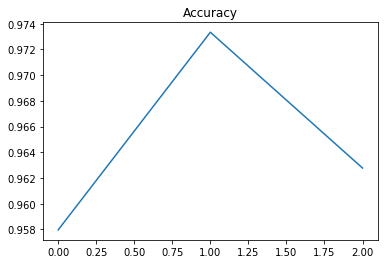

In [107]:
plt.plot(accu_listmi)
plt.title("Accuracy")
plt.show()